In [19]:
%matplotlib inline

#9. Transformer Tutorial

Objective: learn how to apply transformer to a sequence to sequence task.
**A sequence to sequence task is trying to predict the next sentence based on the current sentence.**


Sequence-to-Sequence Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on how to train a sequence-to-sequence model
that uses the
`nn.Transformer <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer>`__ module.

PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You
Need <https://arxiv.org/pdf/1706.03762.pdf>`__. The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention <https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention>`__) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>`__
in this tutorial) can be easily adapted/composed.

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_architecture.jpg?raw=1)





## Drawbacks of LSTM/Seq2Seq

1. Parallel computation unavailable
2. Long-range dependencies

We need a mechanism to solve these two problems


## Transformer


### Self-attention mechanism


![000009.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*LMxtoaou2EAkehmdyJjxaA.png)

The mechanism to identify the relationship between any two tokens of the input

Self attention map is represented by a 2D array

Example: We have a sequence with three tokens, the similarity map is represented as:

|   |  1  |  2  |  3  |
|:-:|:---:|:---:|:---:|
| 1 | 1.0 | 0.8 | 0.4 |
| 2 | 0.8 | 1.0 | 0.5 |
| 3 | 0.4 | 0.5 | 1.0 |

Attention map (apply softmax on similarity map)

|   |  1  |  2  |  3  |
|:-:|:---:|:---:|:---:|
| 1 | 0.45 | 0.36 | 0.18 |
| 2 | 0.34 | 0.43 | 0.21 |
| 3 | 0.21 | 0.26 | 0.52 |



Based on this self-attention mechanism, the model allows to see all the tokens at the same time. (Just solve the drawback of LSTM have to go one by one).

### Key, Value and Query

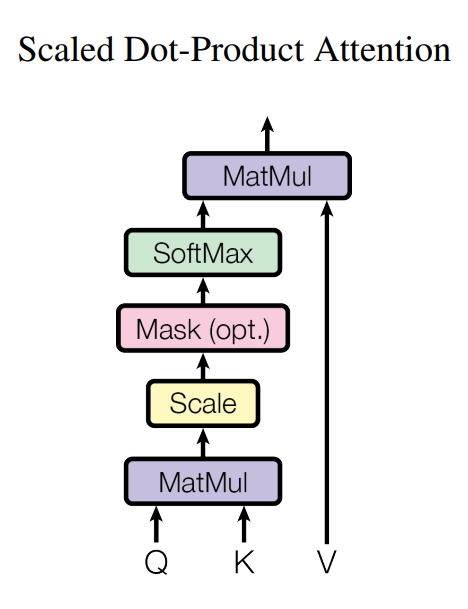

**First question**: How to obtain Q, K an V?

We have sample $X$ is our input has dimension $d_x$, we just need one step to obtain Q, K and V that has the dimension $d$
1. Build the linear network `f = nn.Linear(dx, 3 * d)`
2. Forward the X to the network `Q, K, V = f(X)[0:d], f(X)[d:2d], f(x)[2d:]`

X: N * dx

Q: N * t * d

K: N * t * d

V: N * t * d

Q * K.T: (N * t * t)

A * V: N* t * d

t is the number of tokens







**Second question:** Where is the attention map?

The attention map is after the SoftMax layer. It is calculate via this equation:

$$\text{AttentionMap}(Q, K) = \text{SoftMax}(\frac{Q K^T}{\sqrt{d_k}}) $$

**Third question:** Where is the attention?

It is the matrix multiplication between AttentionMap and the V:

$$\text{Attention}(Q,K, V) = \text{SoftMax}(\frac{Q K^T}{\sqrt{d_k}}) V$$

**Forth question:**: What is $\frac{1}{\sqrt{d_k}}$.

That is the scaling factor to avoid large grow in magnitude leads to gradient vanishing when going through softmax

Q = K = V = Attention (dimension)

Q = K = V = A

## Multi-Head Attention

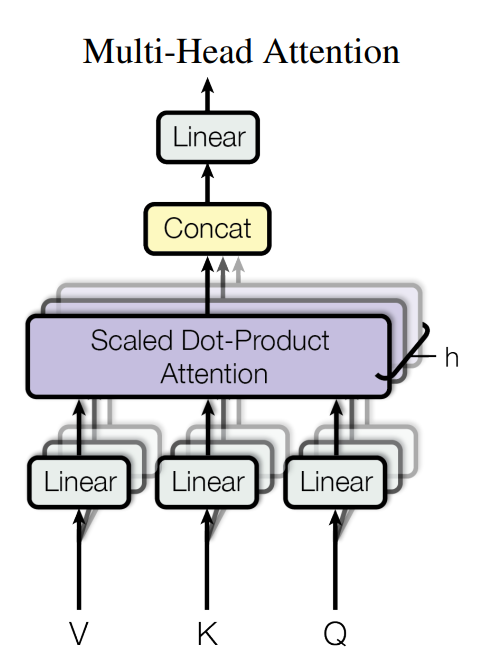

## Encoder

![image.png](https://miro.medium.com/v2/resize:fit:1200/format:webp/1*z5_fCz6uHix-Aae-DoBHkQ.jpeg)

## Decoder

![image.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*BuYhScgQi3D7jNlCLeCJLA.jpeg)

Input
X = x1 x2 x3 x4 x5 (E)

Output groundtruth
y1 y2 y3 y4 (J) (don'thave)

y1_hat (first prediction)


y2_hat = Decoder(Encoder(X), y1_hat, .....)

y3_hat = Decoder(Encoder(X), y1_hat, y2_hat,.....)





With masking

![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*TSaRMCAdImKh4sUiE0DlXg.png)

Without masking

![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*y3IG4W2z6lJpjeFGyL_zng.png)

## Full architecture

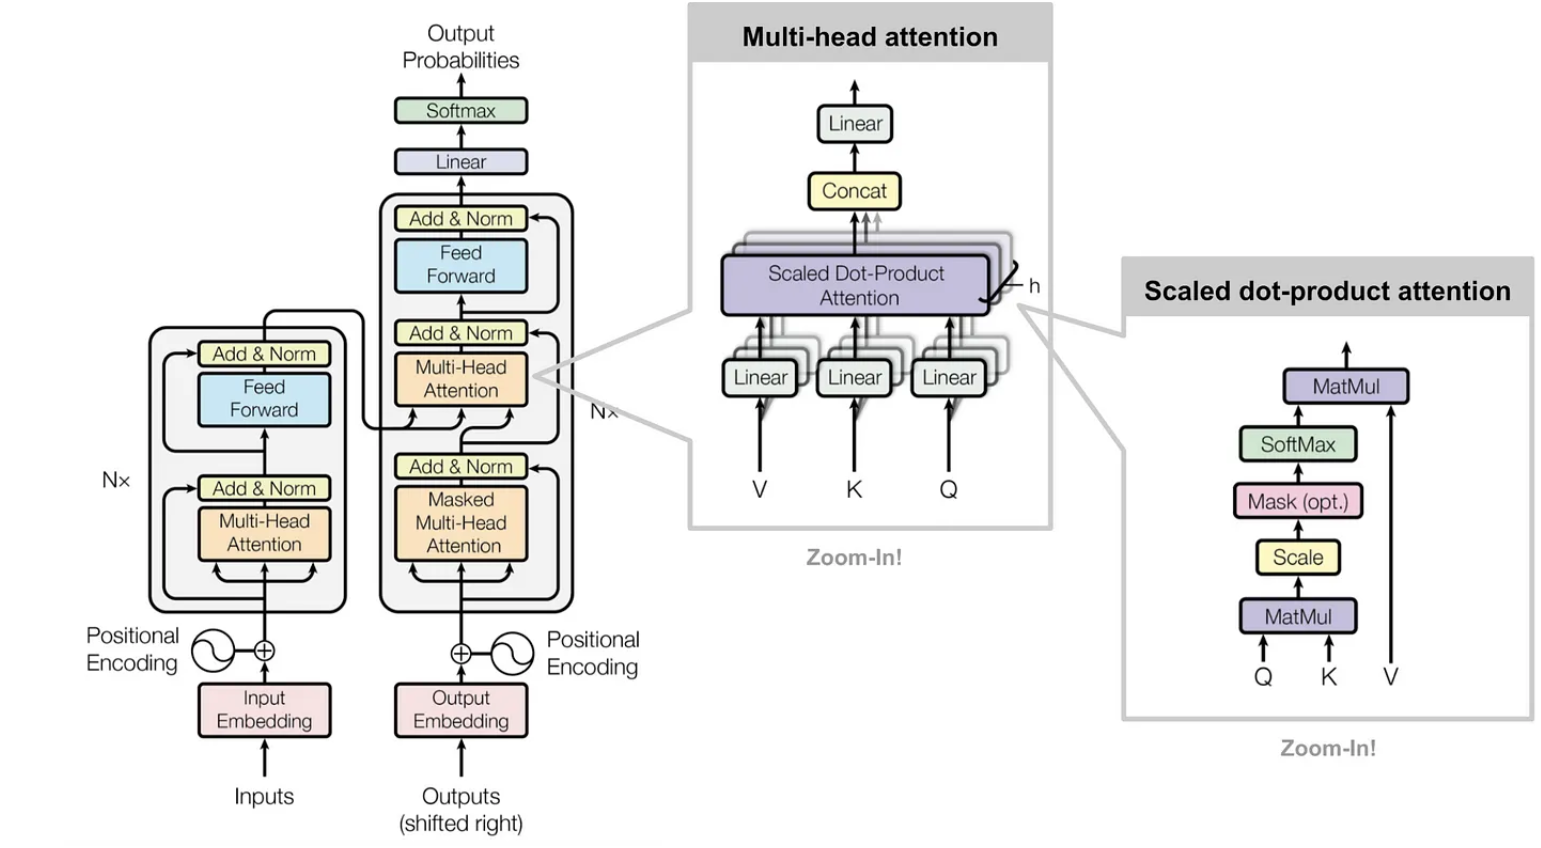

I go to school

<sot> I go to school <eot> <empty> <empty>

input shape: 60
input token length: 6

output shape: 60
output toke length: ?

N * T * d



## Positional Encoding

Relative position encoding:

$$PE_{pos, 2i} = \sin(\frac{pos}{10000^{\frac{2i}{d}}})$$

$$PE_{pos, 2i+1} = \cos(\frac{pos}{10000^{\frac{2i}{d}}})$$

Embedding layer to encoder to encode position

Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




In [20]:
# install important package
# Important: when you run these two lines at the first time, the system might tell you to
# "restart runtime" below, make sure you click it!

!pip install torchtext
!pip install torchdata
!pip install portalocker>=2.0.0

In [12]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [14]:
import torch
from torchtext.datasets import PennTreebank
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = PennTreebank(split='train')
tokenizer = get_tokenizer('basic_english')


vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# def data_process(raw_text_iter):
#   data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
#   return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

def data_process(raw_text_iter):
  for item in raw_text_iter:
    print("________________________________________________________________-")
    print(item)
    token = tokenizer(item)
    print(token)
    print(vocab(token))
    print("________________________________________________________________")
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = PennTreebank()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

Output hidden; open in https://colab.research.google.com to view.

#Functions to generate input and target sequence




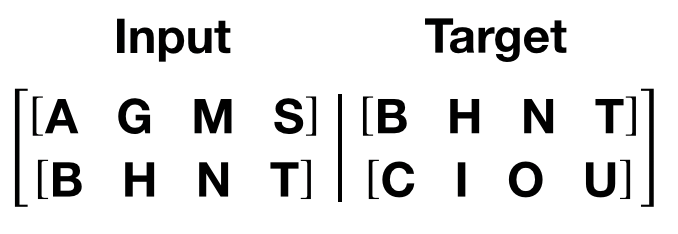





``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [15]:
bptt = 35
# i will go to school tomorrow
# i will go
# will go to
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [16]:
ntokens = len(vocab) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




`CrossEntropyLoss <https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>`__
is applied to track the loss and
`SGD <https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD>`__
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR <https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR>`__ is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_>`__
function to scale all the gradient together to prevent exploding.




In [17]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [18]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   200/ 1320 batches | lr 5.00 | ms/batch 13.01 | loss  7.15 | ppl  1269.06
| epoch   1 |   400/ 1320 batches | lr 5.00 | ms/batch  6.93 | loss  6.09 | ppl   439.44
| epoch   1 |   600/ 1320 batches | lr 5.00 | ms/batch  7.13 | loss  5.84 | ppl   344.90
| epoch   1 |   800/ 1320 batches | lr 5.00 | ms/batch  8.03 | loss  5.66 | ppl   287.96
| epoch   1 |  1000/ 1320 batches | lr 5.00 | ms/batch  7.16 | loss  5.59 | ppl   268.94
| epoch   1 |  1200/ 1320 batches | lr 5.00 | ms/batch  6.94 | loss  5.48 | ppl   240.20
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.10s | valid loss  5.48 | valid ppl   238.72
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1320 batches | lr 4.75 | ms/batch  8.02 | loss  5.42 | ppl   225.96
| epoch   2 |   400/ 1320 batches | lr 4.75 | ms/batch  6.91 | loss  5.36 | ppl   212.52
| epoch   2 |   600/ 1320 batches 

Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [ ]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

NameError: ignored